# Hottest Day Date
This plays around with what determines the date of the hottest day of the year in a given region.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.aquaplanet_theory import get_delta_temp_quant_theory, get_gamma
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils import area_weight_mean_lat, area_weighting, annual_mean, annual_time_slice
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy

2023-06-30 16:02:32,393 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [2]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height', 'swdn_toa', 'ps', 't_surf', 'olr', 'swdn_sfc', 'lwdn_sfc', 'flux_t', 'flux_lhe',
            'precipitation', 'vcomp', 'ucomp', 'omega']
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    p_surface = float(ds_use.pfull[-1]) * 100
    ds += [ds_use.sel(pfull=np.inf, method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Only consider one location (latitude and longitude) - see how date of hottest day varies in different years.

In [3]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True
high_dpi = 350
low_dpi = 100

In [60]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

loc = {'lat':15, 'lon': 180}

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.sel(lat=loc['lat'], lon=loc['lon'], method='nearest')
        ds_all += [ds_use.load()]
        pbar.update(1)

100%|██████████| 2/2 [00:06<00:00,  3.30s/it]


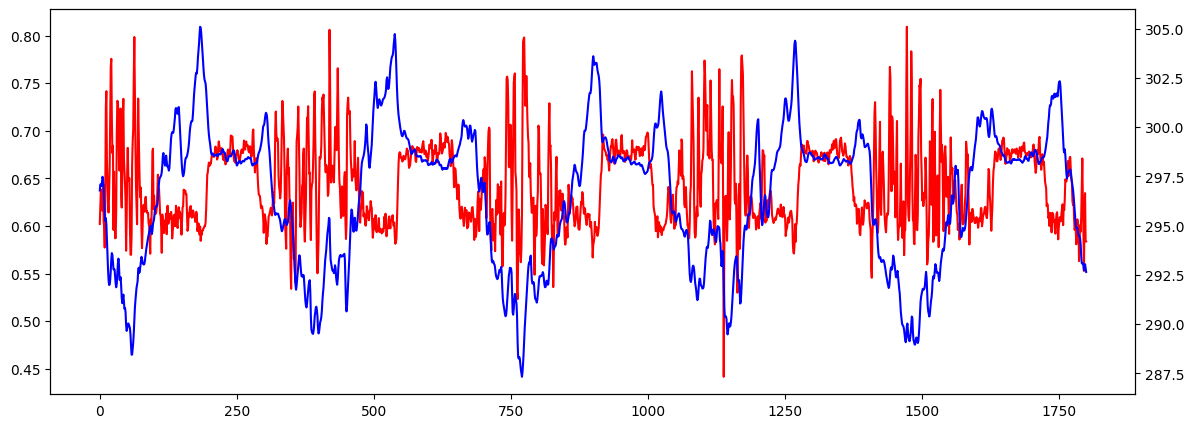

In [61]:
fig, ax = plt.subplots(1,1, figsize=(14, 5))
sw_toa_down = np.asarray([frierson_net_toa_sw_dwn(ds_all[i].swdn_toa, ds_all[i].ps, albedo[i], tau_sw[i]) for i in range(n_exp)])
# plt.plot(sw_toa_down[0])
# plt.plot(sw_toa_down[1])
# ax.plot(ds_all[0].temp)
ax2 = ax.twinx()
ax.plot(ds_all[0].sphum/sphum_sat(ds_all[0].temp,p_surface), color='r')
ax2.plot(ds_all[0].t_surf, color='b')

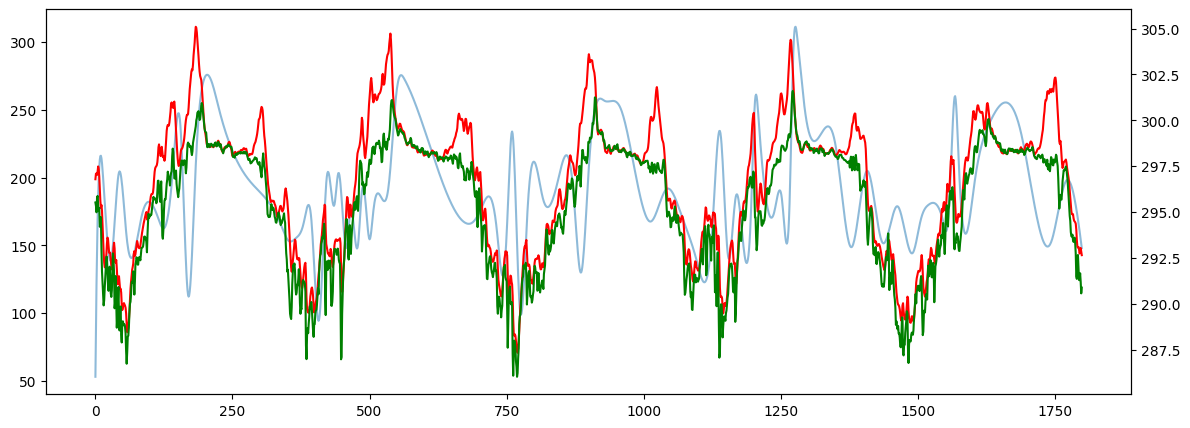

In [62]:
import scipy.interpolate
fig, ax = plt.subplots(1,1, figsize=(14, 5))
spl = scipy.interpolate.UnivariateSpline(ds_all[0].time,ds_all[0].flux_lhe, s=5000000)
#ax.plot(ds_all[0].flux_lhe)
ax.plot(spl(ds_all[0].time), alpha=0.5)
#spl(ds_all[0].time) - ds_all[0].flux_lhe
ax2 = ax.twinx()
ax2.plot(ds_all[0].t_surf, color='r')
ax2.plot(ds_all[0].temp, color='g')

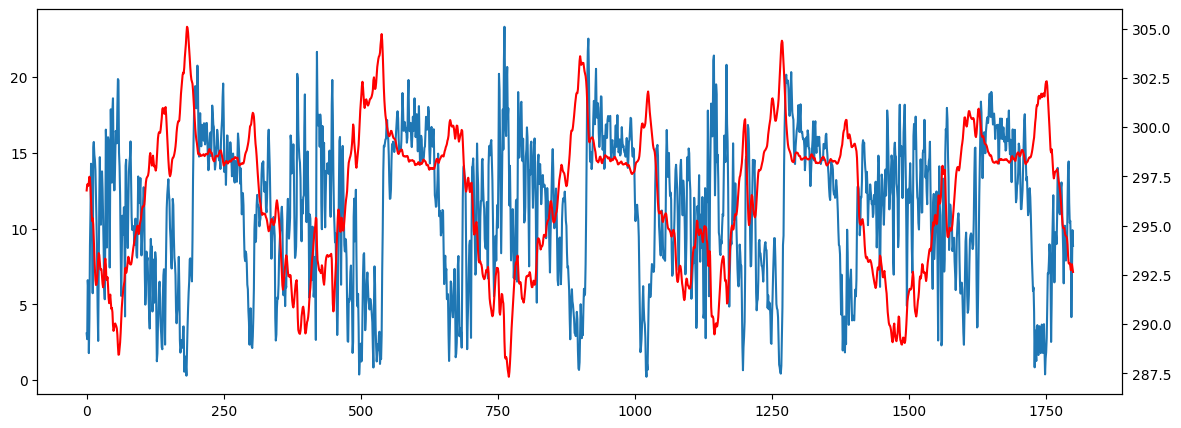

In [63]:
fig, ax = plt.subplots(1,1, figsize=(14, 5))
ax.plot(np.sqrt(ds_all[0].vcomp**2+ds_all[0].ucomp**2))
# ax.plot(-ds_all[0].omega*1000)
ax2 = ax.twinx()
ax2.plot(ds_all[0].t_surf, color='r')

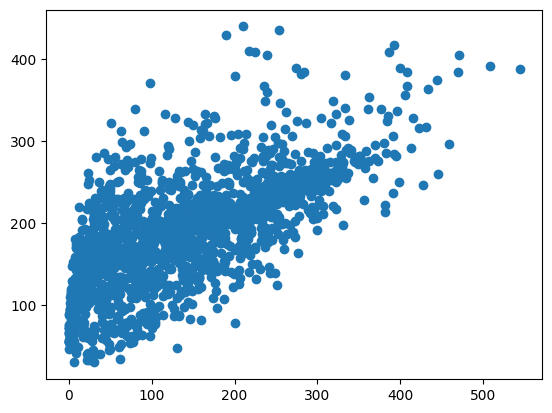

In [64]:
plt.scatter(ds_all[0].vcomp**2+ds_all[0].ucomp**2, ds_all[0].flux_lhe)

In [65]:
# Take annual mean to see how temperature varies within a year on average
ds_annual_mean = [annual_mean(ds_all[i]) for i in range(n_exp)]
# Compute times corresponding to peaks in surface temperature
max_summer_time = ds_annual_mean[0].time[ds_annual_mean[0].time<8*30][
    np.argmax(ds_annual_mean[0].t_surf[ds_annual_mean[0].time<8*30].to_numpy())]
max_winter_time = ds_annual_mean[0].time[ds_annual_mean[0].time>8*30][
    np.argmax(ds_annual_mean[0].t_surf[ds_annual_mean[0].time>8*30].to_numpy())]

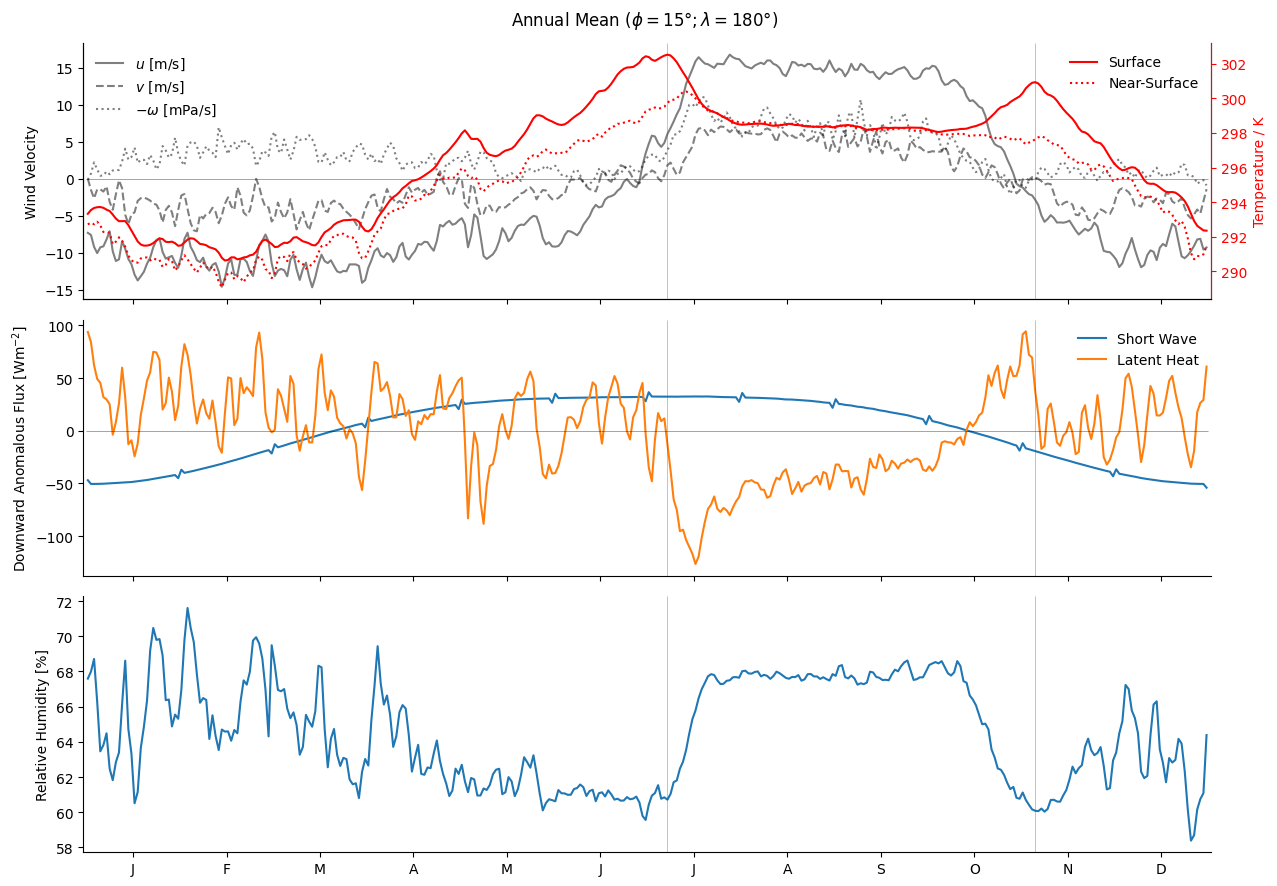

In [66]:
month_ticks = (np.arange(15,12*30+15,30), ['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, ax = plt.subplots(3,1, figsize=(13, 9), sharex=True)
ax2 = ax[0].twinx()
#ax2.set_ylim(-0.012,0.012)
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].ucomp, alpha=0.5, color='k', label='$u$ [m/s]')
ax[0].plot(ds_annual_mean[0].time, ds_annual_mean[0].vcomp, color='k', alpha=0.5, linestyle='--', label='$v$ [m/s]')
ax[0].plot(ds_annual_mean[0].time, -ds_annual_mean[0].omega*1000, color='k', alpha=0.5, linestyle=':', label='$-\omega$ [mPa/s]')
ax[0].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlim(-1,361)
# ax[0].set_ylim(-18,18)
ax[0].set_ylabel('Wind Velocity')
ax[0].legend(frameon=False)
ax[0].legend(frameon=False, loc='upper left')

ax2.spines['top'].set_visible(False)
ax2.plot(ds_annual_mean[0].time, ds_annual_mean[0].t_surf, color='r', label='Surface')
ax2.plot(ds_annual_mean[0].time, ds_annual_mean[0].temp, color='r', linestyle=':', label='Near-Surface')
ax2.tick_params(axis='y', colors='red')
ax2.spines['right'].set_color('red')
ax2.legend(frameon=False, loc='upper right')
ax2.set_ylabel('Temperature / K', color='r')

ax[1].plot(ds_annual_mean[0].time, ds_annual_mean[0].swdn_sfc-np.mean(ds_annual_mean[0].swdn_sfc), label='Short Wave')
ax[1].plot(ds_annual_mean[0].time, -(ds_annual_mean[0].flux_lhe-np.mean(ds_annual_mean[0].flux_lhe)), label='Latent Heat')
# ax[1].plot(ds_annual_mean[0].swdn_sfc - ds_annual_mean[0].flux_lhe)
ax[1].hlines(0,0,360, color='k', linewidth=0.5, alpha=0.5)
ax[1].spines[['right', 'top']].set_visible(False)
ax[1].set_ylabel('Downward Anomalous Flux [Wm$^{-2}$]')
ax[1].legend(frameon=False)

ax[2].plot(ds_annual_mean[0].time, 100*ds_annual_mean[0].sphum/sphum_sat(ds_annual_mean[0].temp,p_surface))
ax[2].set_xticks(*month_ticks)
ax[2].spines[['right', 'top']].set_visible(False)
ax[2].set_ylabel('Relative Humidity [%]')

for ax_use in ax.flatten():
    ylim = ax_use.get_ylim()
    ax_use.vlines([max_summer_time, max_winter_time], *ylim, color='g', alpha=0.6, linewidth=0.4)
    ax_use.set_ylim(ylim)

fig.suptitle(f"Annual Mean ($\phi={loc['lat']}\degree; \lambda={loc['lon']}\degree$)")
plt.tight_layout()